In [1]:
from __future__ import print_function
from fenics import *
# from dolfin_adjoint import *
import mshr
import numpy as np

### Create mesh and define function space

In [2]:
# Create mesh and define function space
filepath = 'test_sample_deform/bulk/'

In [3]:
# Sample Geometry
L = 1
H = 1
cx = [.0,1]
cy = [.40,.60]
R = [.05,.05]

Circle_i = lambda i: mshr.Circle(Point(cx[i],cy[i]), R[i])
Circles = list(map(Circle_i, [i for i, e in enumerate(R) if e != 0]))
[i for i, e in enumerate(R) if e != 0]

[0, 1]

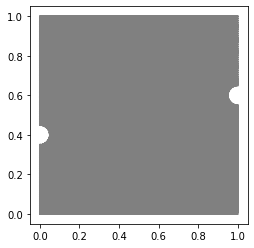

In [4]:
L = 1
H = 1
def hole(obj,holes):
    obj_with_holes = obj
    for i in range(len(holes)):
        obj_with_holes = obj_with_holes - holes[i]
    return obj_with_holes

domain = hole(mshr.Rectangle(Point(0.,0.), Point(L, H)),Circles)
mesh = mshr.generate_mesh(domain, 100)
n_elements = mesh.coordinates().shape[0]
plot(mesh)

### Constitutive relation

In [5]:
# Mechanical Properties
E_m = 1e6
E = Constant(1*E_m)
nu = Constant(0.3)
sigma_y0 = Constant(0.01*E_m) # yield stress

mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)
lmbda = 2*mu*lmbda/(lmbda+2*mu)

In [6]:
def sigmoid(x):
    s = 1/(1+exp(-x))
    return s
def tanh(x):
    t = (exp(2*x)-1)/(exp(2*x)+1)
    return t

In [7]:
# Constitutive relation
def epsilon(u):
    return sym(grad(u))

def sigma_el(epsilon):
    return lmbda*tr(epsilon)*Identity(2) + 2*mu*epsilon

def sigma_yield(epsilon):
    return sigma_y0 + 0.1*sigma_y0*tanh(epsilon*10)

def epsilon_pl(d_epsilon, sigma_old, epsilon_old,kappa_value=100):
    '''
    inputs
    d_epsilon: strain increment
    sigma_old: stress tensor at the increment n
    epsilon_old: plastic strain tensor
    kappa_value: sharpness of the sigmoid function
    '''
    kappa = Constant(kappa_value)
    
    sigma_y = sigma_yield(epsilon_old)
    H = diff(sigma_y, epsilon_old)
    
    sigma_pr = sigma_old + sigma_el(d_epsilon) # trial stress
    sigma_pr_dev = dev(sigma_pr) # deviatoric elastic stress
    sigma_ef = sqrt(3/2.*inner(sigma_pr_dev, sigma_pr_dev) + DOLFIN_EPS) # effective von Mises stress
    
    sgn = (sigma_ef - sigma_y)/(abs(sigma_ef - sigma_y) + DOLFIN_EPS)
    f_sigmoid = sigmoid(kappa*(sigma_ef - sigma_y)*sgn) # the indicator function
    f_ind = (f_sigmoid-0.5)*sgn + 0.5
    
    d_epsilon_pl_sc = f_ind*(sigma_ef - sigma_y)/(3*mu + H) # plastic strain increment (scalar)
    n_pr = dev(sigma_pr) / sigma_ef
    d_epsilon_pl = d_epsilon_pl_sc*3/2*n_pr
    
    return d_epsilon_pl

def Constitutive_function(sig_n, du, ep_n, dt=1E-3):
    d_epsilon_el = epsilon(du) # elastic strain increment
    d_epsilon_pl = epsilon_pl(d_epsilon_el,sig_n,ep_n) # plastic strain increment
    d_epsilon = d_epsilon_el - d_epsilon_pl
    dot_p = sqrt(inner(d_epsilon_pl,d_epsilon_pl)*2.0/3.0 + DOLFIN_EPS) #Accumulated plastic strain rate
    return sig_n + sigma_el(d_epsilon), dot_p

In [8]:
def mis_ep(u):
    eps_dev = epsilon(u) - Identity(2)*tr(epsilon(u))
    mis = sqrt(3/2*inner(eps_dev,eps_dev))
    return mis

def mis_sig(sig):
    sigma_dev = sig - Identity(2)*tr(sig)
    mis = sqrt(3/2*inner(sigma_dev,sigma_dev))
    return mis

In [11]:
Time = 40
num_steps = 40
e_tot = 0.01

def solve_plastic_system(mesh, Time, num_steps, constitutive_func, loss_func=lambda n,x: 0, tol = 1.0E-14):
    dt = Time / num_steps # time step size
    
    # Define function space for displacement
    S = FunctionSpace(mesh, 'P', 1)
    V = VectorFunctionSpace(mesh, 'P', 1)
    T = TensorFunctionSpace(mesh, 'P', 1)
    
    # Define test functions
    v  = TestFunction(V)
    du = TrialFunction(V)
    
    # Define functions for dsiplacement
    u     = Function(V)
    u_n   = Function(V)
    sig   = Function(T)
    sig_n = Function(T)
    ep    = Function(S)
    ep_n  = Function(S)

    # Define boundary 
    def BC_y0(x, on_boundary):
        return on_boundary and near(x[1], 0, tol)
    def BC_y1(x, on_boundary):
        return on_boundary and near(x[1], 1, tol)
    bcD = DirichletBC(V.sub(1), 0,    BC_y0)
    def BC_corner(x, on_boundary):
        return near(x[1], 0, tol) and near(x[0], 0, 2e-2)
    bc_corner = DirichletBC(V.sub(0), 0,    BC_corner)
    
    
    # Time-stepping
    t = 0
    results = []
    
    File_displacement = File(filepath+'displacement_AG.pvd')
    File_stress_Mis = File(filepath+'stress_Mis_AG.pvd')
    File_strain_Mis = File(filepath+'strain_Mis_AG.pvd')
    File_strain_AG = File(filepath+'strain_AG.pvd')
    File_stess_AG = File(filepath+'stess_AG.pvd')
    
    array_u = np.zeros((n_elements,2,num_steps+1))
    array_sigma = np.zeros((n_elements,2,2,num_steps+1))
    array_epsilon = np.zeros((n_elements,2,2,num_steps+1))
    
    for n in range(num_steps+1):
        print(n)
        displacement = float(e_tot/num_steps*n)
        bcU = DirichletBC(V.sub(1), displacement, BC_y1)
        BC = [bcU, bcD, bc_corner]
        
        # Define variational problem
        sig, dep = constitutive_func(sig_n, u-u_n, ep_n, dt=dt)
        F = inner(sig, epsilon(v))*dx
        
        # Update current time
        t = t + dt
        
        # Solve variational problem for time step
        J = derivative(F, u, du)
        problem = NonlinearVariationalProblem(F, u, BC, J)
        solver = NonlinearVariationalSolver(problem)
        solver.solve()
        
        # Update previous solution
        sig = project(sig, T)
        ep = project(ep_n+dep, S)
        
        sig_n.assign(sig)
        u_n.assign(u)
        ep_n.assign(ep)
        print('end')
        
        # Save solution to file in VTK format
        sig_Mis = project(mis_sig(sig),S)
        ep_Mis = project(mis_ep(u),S)
#         sig_Mis = mis_sig(sig)
#         ep_Mis = mis_ep(u)
        epsilon_u = epsilon(u)
        
        u.rename('$u$','displacement')
        sig.rename('$\sigma$','stress')
        ep.rename('$\epsilon$','strain')
        sig_Mis.rename('$\sigma_{VM}$','stress_Mis')
        ep_Mis.rename('$\epsilon_{VM}$','strain_Mis')
        
        File_displacement << (u,t)
        File_stress_Mis << (sig_Mis,t)
        File_strain_Mis << (ep_Mis)
        File_strain_AG << (ep,t)
        File_stess_AG << (sig,t)
        
        # Save element vectors in .mat format
        from scipy.io import savemat
        array_u[:,:,n] = np.array(u.vector()).reshape(n_elements,2)
        
        epsilon_u = epsilon(u)
        epsilon_u = project(epsilon(u),T)
        array_epsilon[:,:,:,n] = np.array(epsilon_u.vector()).reshape(n_elements,2,2)
        
        array_sigma[:,:,:,n] = np.array(sig.vector()).reshape(n_elements,2,2)
        
    mdic = {'u':array_u, 'epsilon':array_epsilon, 'sigma':array_sigma}
    savemat(filepath+'data.mat', mdic)
        
    return ep, sig, u, sig_Mis, ep_Mis

In [12]:
ep, sig, u, sig_Mis, ep_Mis = solve_plastic_system(mesh, Time, num_steps, Constitutive_function)

0
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 0.000e+00 (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
end
1
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.971e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 4.670e-04 (tol = 1.000e-10) r (rel) = 1.572e-04 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 4.968e-05 (tol = 1.000e-10) r (rel) = 1.672e-05 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.466e-08 (tol = 1.000e-10) r (rel) = 4.935e-09 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 7.404e-14 (tol = 1.000e-10) r (rel) = 2.492e-14 (tol = 1.000e-09)
  Newton solver finished in 4 iterations and 4 linear solver iterations.
end
2
Solving nonlinear variati

end
19
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 9.070e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.467e-05 (tol = 1.000e-10) r (rel) = 1.617e-04 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 2.399e-07 (tol = 1.000e-10) r (rel) = 2.645e-06 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.098e-10 (tol = 1.000e-10) r (rel) = 1.211e-09 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 5.589e-16 (tol = 1.000e-10) r (rel) = 6.163e-15 (tol = 1.000e-09)
  Newton solver finished in 4 iterations and 4 linear solver iterations.
end
20
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 9.070e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.222e-05 (tol = 1.000e-10) r (rel) = 2.450e-04 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 7.543e-07 (tol = 1.000e-10) r (rel) = 8.316e-06 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.758e-09 (tol = 1.

end
33
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 9.099e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 7.101e-05 (tol = 1.000e-10) r (rel) = 7.803e-04 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.122e-05 (tol = 1.000e-10) r (rel) = 1.233e-04 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 4.861e-07 (tol = 1.000e-10) r (rel) = 5.343e-06 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 5.875e-10 (tol = 1.000e-10) r (rel) = 6.457e-09 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 1.300e-15 (tol = 1.000e-10) r (rel) = 1.428e-14 (tol = 1.000e-09)
  Newton solver finished in 5 iterations and 5 linear solver iterations.
end
34
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 9.098e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 7.773e-05 (tol = 1.000e-10) r (rel) = 8.543e-04 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.273e-05 (tol = 1.

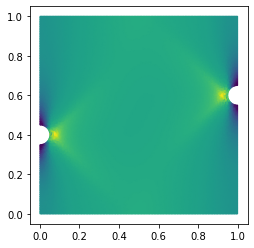

In [13]:
S = FunctionSpace(mesh, 'P', 2)
sigma_Mis = project(mis_sig(sig),S)
plot(sig_Mis, mode='color')